Ambiguity, in financial contexts, refers to uncertainty that is difficult or impossible to quantify with precise probabilities. Unlike traditional risk—which can be measured through statistical measures such as variance or volatility—ambiguity addresses situations where the probability distribution itself is uncertain or poorly understood.

In the context of stock data, ambiguity can be thought of as uncertainty about the distribution of returns. A common and practical approach to quantifying ambiguity involves measuring the instability or uncertainty in estimates of expected returns or volatility over different historical time windows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd

def load_and_prepare_data(file_path):
    # Read the CSV with the expected columns
    df = pd.read_csv(file_path, usecols=['datetime_nano', 'SSE.000300.close'])
    df.rename(columns={'SSE.000300.close': 'close'}, inplace=True)
    
    # Convert 'datetime_nano' to a datetime object.
    # First interpret as UTC date, then convert to local time (Asia/Shanghai), then floor to minute.
    df['datetime'] = (pd.to_datetime(df['datetime_nano'], utc=True)
                        .dt.tz_convert('Asia/Shanghai')
                        .dt.floor('min')
                        .dt.tz_localize(None))
    df.drop('datetime_nano', axis=1, inplace=True)
    
    # Sort by datetime
    df.sort_values('datetime', inplace=True)
    
    return df

# Example usage:
file_path = '../../data/SSE.000300.csv'  # Ensure the path is correct
df = load_and_prepare_data(file_path)

# Calculate minute returns
df['returns'] = df['close'].pct_change()

# Extract the date part
df['date'] = df['datetime'].dt.date

# Rearrange the DataFrame columns so that the order is: date, datetime, close, returns
df = df[['date', 'datetime', 'close', 'returns']]
df.dropna(inplace=True)

print(df.head())

         date            datetime    close   returns
1  2018-01-02 2018-01-02 09:31:00  4052.21 -0.000585
2  2018-01-02 2018-01-02 09:32:00  4052.53  0.000079
3  2018-01-02 2018-01-02 09:33:00  4054.50  0.000486
4  2018-01-02 2018-01-02 09:34:00  4059.93  0.001339
5  2018-01-02 2018-01-02 09:35:00  4064.32  0.001081


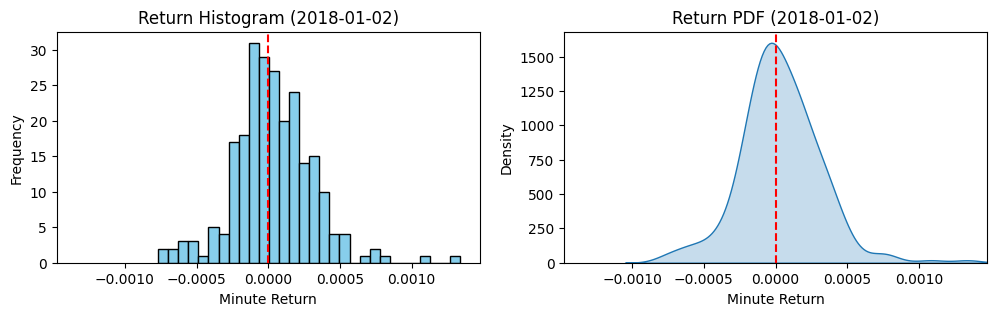

In [4]:
def plot_return_distribution(df, specific_date, bins=30, ax_hist=None, ax_pdf=None):
    """
    Plots the histogram and PDF of minute returns for a specific date,
    ensuring a symmetric x-axis with 0 in the middle. Optionally, the plots
    will be drawn on the provided matplotlib axes.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        specific_date (str or date-like): Date string (e.g. "2018-01-02") to filter the data.
        bins (int, optional): Number of bins for the histogram. Defaults to 30.
        ax_hist (matplotlib.axes.Axes, optional): Axis for the histogram plot.
        ax_pdf (matplotlib.axes.Axes, optional): Axis for the density (PDF) plot.
    """
    # Filter out the data for the specified date
    day_df = df[df['datetime'].dt.date == pd.to_datetime(specific_date).date()]
    
    if day_df.empty:
        print(f"No data found for {specific_date}.")
        return
    
    # Use the 'returns' column and drop NaN values
    returns = day_df['returns'].dropna()
    
    # Compute symmetric limits for the x-axis with a 10% margin
    max_abs_value = max(abs(returns.min()), abs(returns.max()))
    lim = max_abs_value * 1.1
    
    # If axes are not provided, create new ones (useful for standalone plots)
    if ax_hist is None or ax_pdf is None:
        fig, (ax_hist, ax_pdf) = plt.subplots(ncols=2, figsize=(12, 3))
    
    # Plot the histogram
    ax_hist.hist(returns, bins=bins, color='skyblue', edgecolor='black')
    ax_hist.set_title(f"Return Histogram ({specific_date})")
    ax_hist.set_xlabel('Minute Return')
    ax_hist.set_ylabel('Frequency')
    ax_hist.set_xlim(-lim, lim)
    ax_hist.axvline(0, color='red', linestyle='--')
    
    # Plot the PDF using seaborn's kdeplot
    sns.kdeplot(returns, fill=True, ax=ax_pdf)
    ax_pdf.set_title(f"Return PDF ({specific_date})")
    ax_pdf.set_xlabel('Minute Return')
    ax_pdf.set_ylabel('Density')
    ax_pdf.set_xlim(-lim, lim)
    ax_pdf.axvline(0, color='red', linestyle='--')
    
plot_return_distribution(df, '2018-01-02')

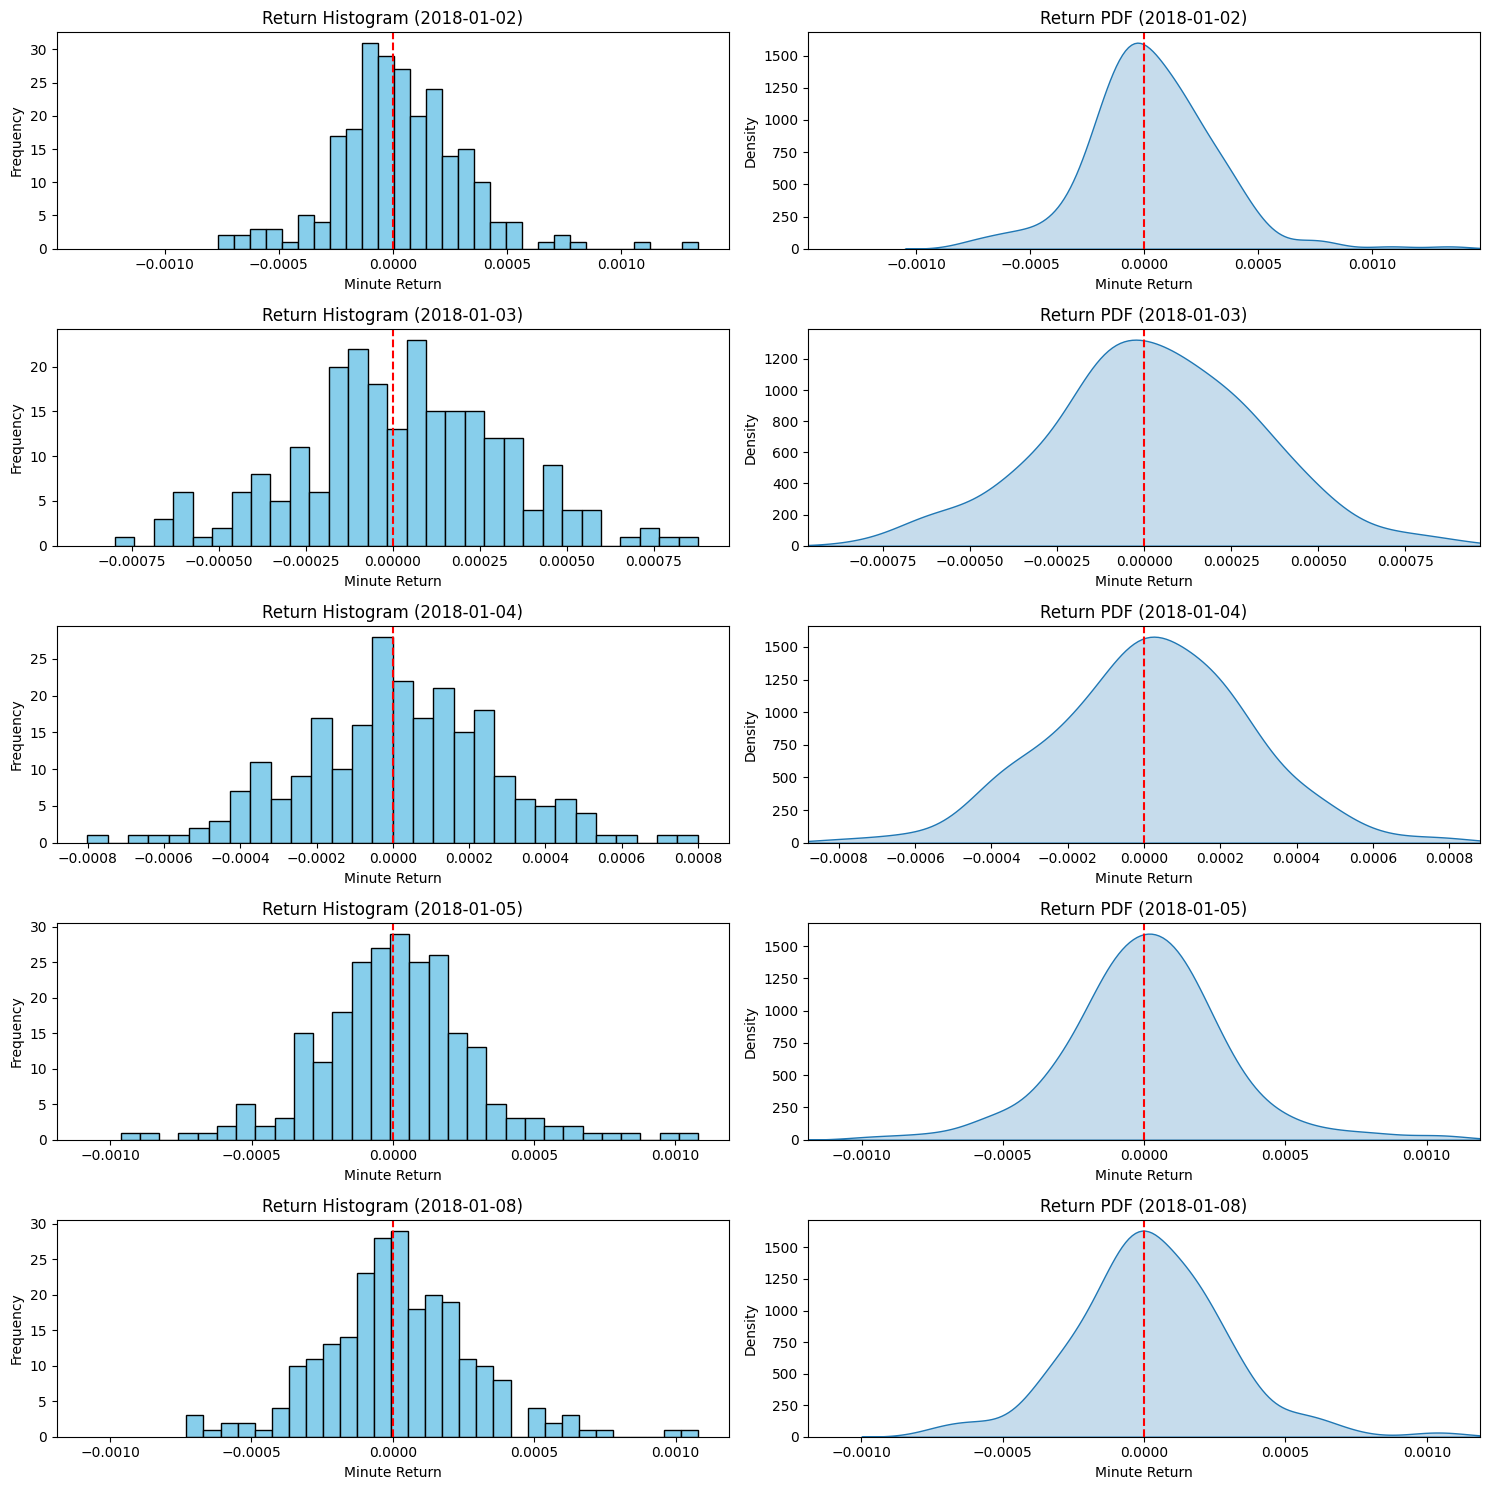

In [5]:
target_date = pd.to_datetime('2018-01-02').date()
unique_dates = sorted(df['date'].unique())
selected_dates = [d for d in unique_dates if d >= target_date][:5]

if len(selected_dates) < 5:
    print("Not enough trading days available!")
else:
    # Create a figure with 5 rows and 2 columns of subplots
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
    
    # Loop over each selected day and plot the histogram and PDF on the corresponding axes
    for i, day in enumerate(selected_dates):
        # Pass the day (as a string) to the function along with the histogram and PDF axes
        plot_return_distribution(df, specific_date=str(day), bins=30,
                                 ax_hist=axs[i, 0], ax_pdf=axs[i, 1])
    
    plt.tight_layout()
    plt.show()

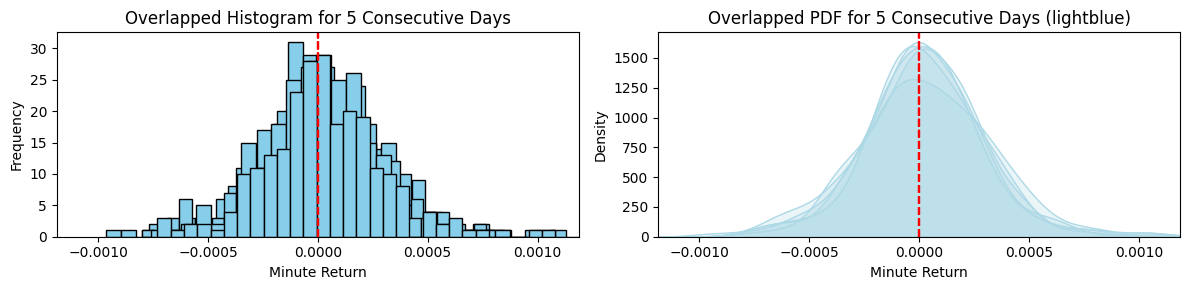

In [6]:
target_date = pd.to_datetime('2018-01-02').date()
unique_dates = sorted(df['date'].unique())
selected_dates = [d for d in unique_dates if d >= target_date][:5]

if len(selected_dates) < 5:
    print("Not enough trading days available!")
else:
    # Create shared axes for histogram and PDF overlaid together
    fig, (ax_hist, ax_pdf) = plt.subplots(ncols=2, figsize=(12, 3))
    
    # FORCE the PDF axis to always use "lightblue" for the PDF curves 
    # (this sets the color cycle to only include that one color)
    ax_pdf.set_prop_cycle(color=['lightblue'])
    
    # Loop over each selected day and overlay the plots on the same axes
    for day in selected_dates:
        plot_return_distribution(df, specific_date=str(day), bins=30,
                                 ax_hist=ax_hist, ax_pdf=ax_pdf)
    
    # Optionally, update the titles to indicate these plots are overlapped
    ax_hist.set_title("Overlapped Histogram for 5 Consecutive Days")
    ax_pdf.set_title("Overlapped PDF for 5 Consecutive Days (lightblue)")
    
    plt.tight_layout()
    plt.show()

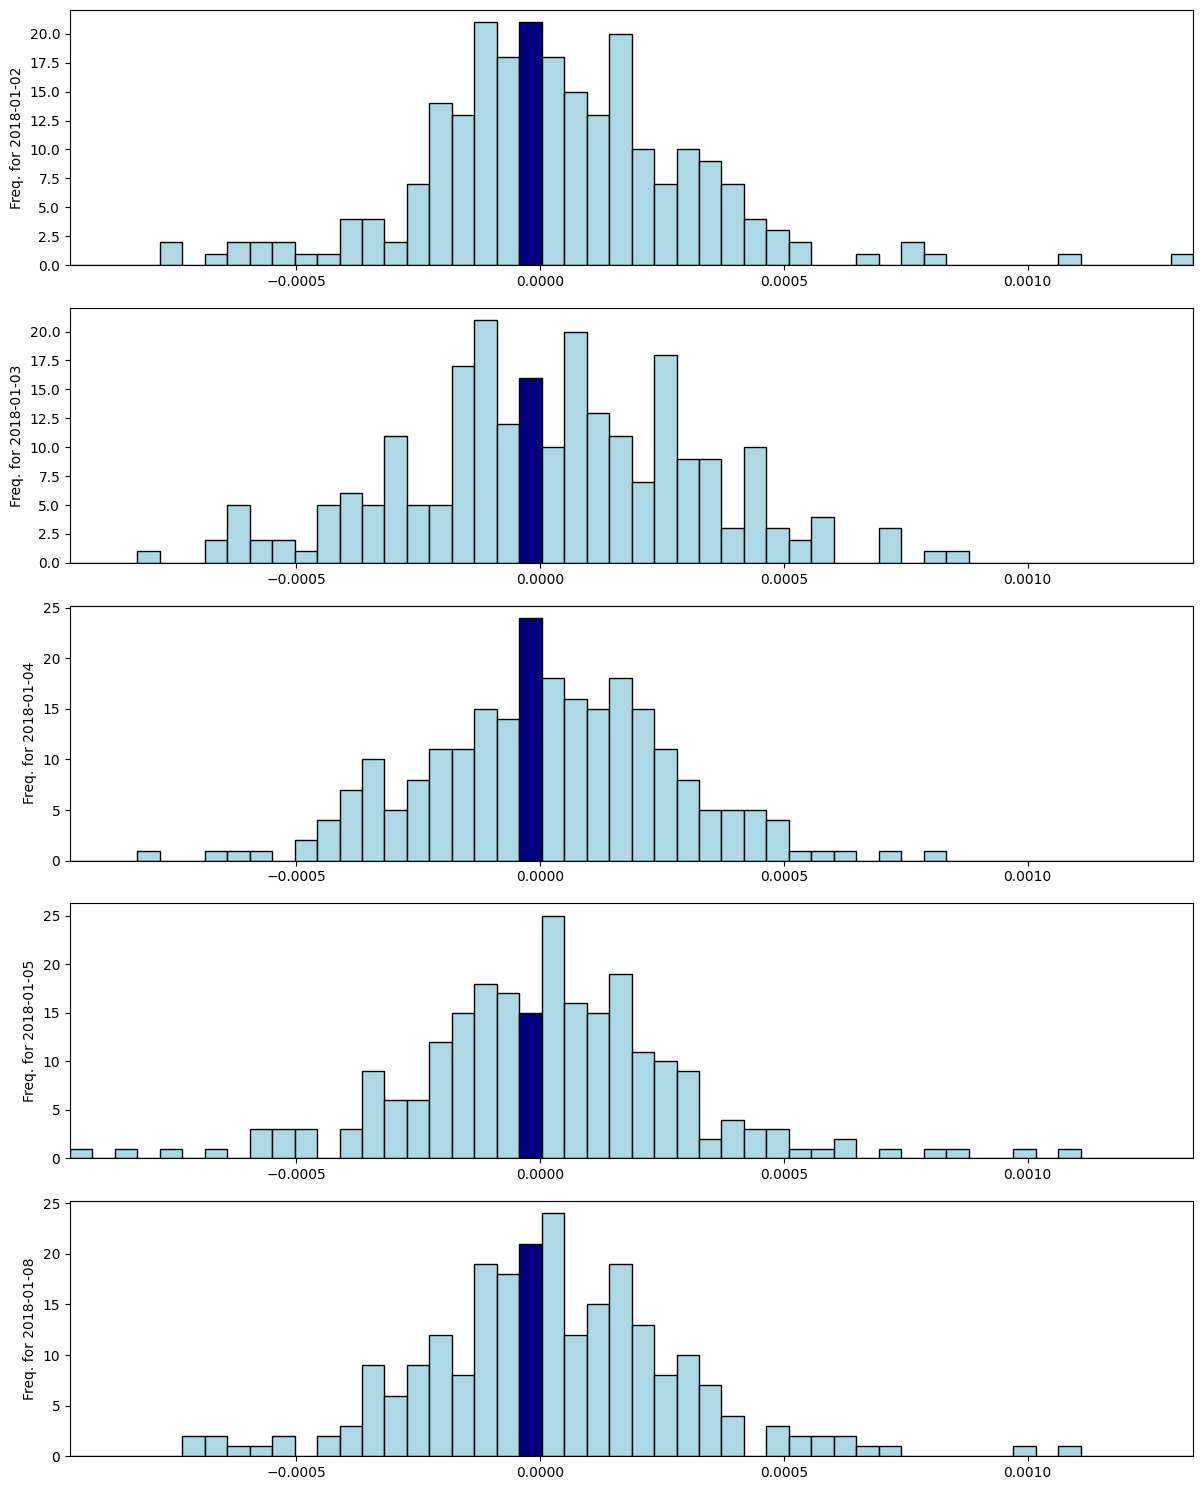

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Assume 'df' already exists with columns:
#   - 'datetime': datetime objects
#   - 'returns': computed minute returns
#   - 'date': typically added via: df['date'] = df['datetime'].dt.date

# First, determine five consecutive trading days starting from 2018-01-02.
target_date = pd.to_datetime('2018-01-02').date()
unique_dates = sorted(df['date'].unique())
selected_dates = [d for d in unique_dates if d >= target_date][:5]

if len(selected_dates) < 5:
    print("Not enough trading days available!")
else:
    # Collect data for only the selected five days to determine global bin edges.
    selected_data = df[df['date'].isin(selected_dates)]
    
    # Compute global minimum and maximum returns among these days.
    global_min = selected_data['returns'].min()
    global_max = selected_data['returns'].max()
    
    # Create uniform bins across all days – 50 bins means 51 bin edges.
    bin_edges = np.linspace(global_min, global_max, 51)
    
    # Create a 5 row x 1 column subplot
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 15))
    
    # Loop over each selected day and plot its histogram using the common bin edges.
    for i, day in enumerate(selected_dates):
        day_df = df[df['date'] == day]
        # Drop NaN returns (if any)
        returns = day_df['returns'].dropna() 
        
        # Plot histogram; return values include counts, bin edges, and the bar patches.
        counts, bins, patches = axs[i].hist(returns, bins=bin_edges, edgecolor='black')
        
        #axs[i].set_title(f"Histogram of Returns for {day}")
        #axs[i].set_xlabel("Minute Return")
        axs[i].set_ylabel(f"Freq. for {day}")
        axs[i].set_xlim(global_min, global_max)
        
        # Iterate over each patch (histogram bar) and set its face color.
        # All bars are "lightblue" except the one whose bin interval contains 0, which is "navy".
        for patch in patches:
            x = patch.get_x()
            width = patch.get_width()
            # Check if the interval [x, x+width) contains 0.
            if x <= 0 < x + width:
                patch.set_facecolor("navy")
            else:
                patch.set_facecolor("lightblue")
    
    plt.tight_layout()
    plt.show()

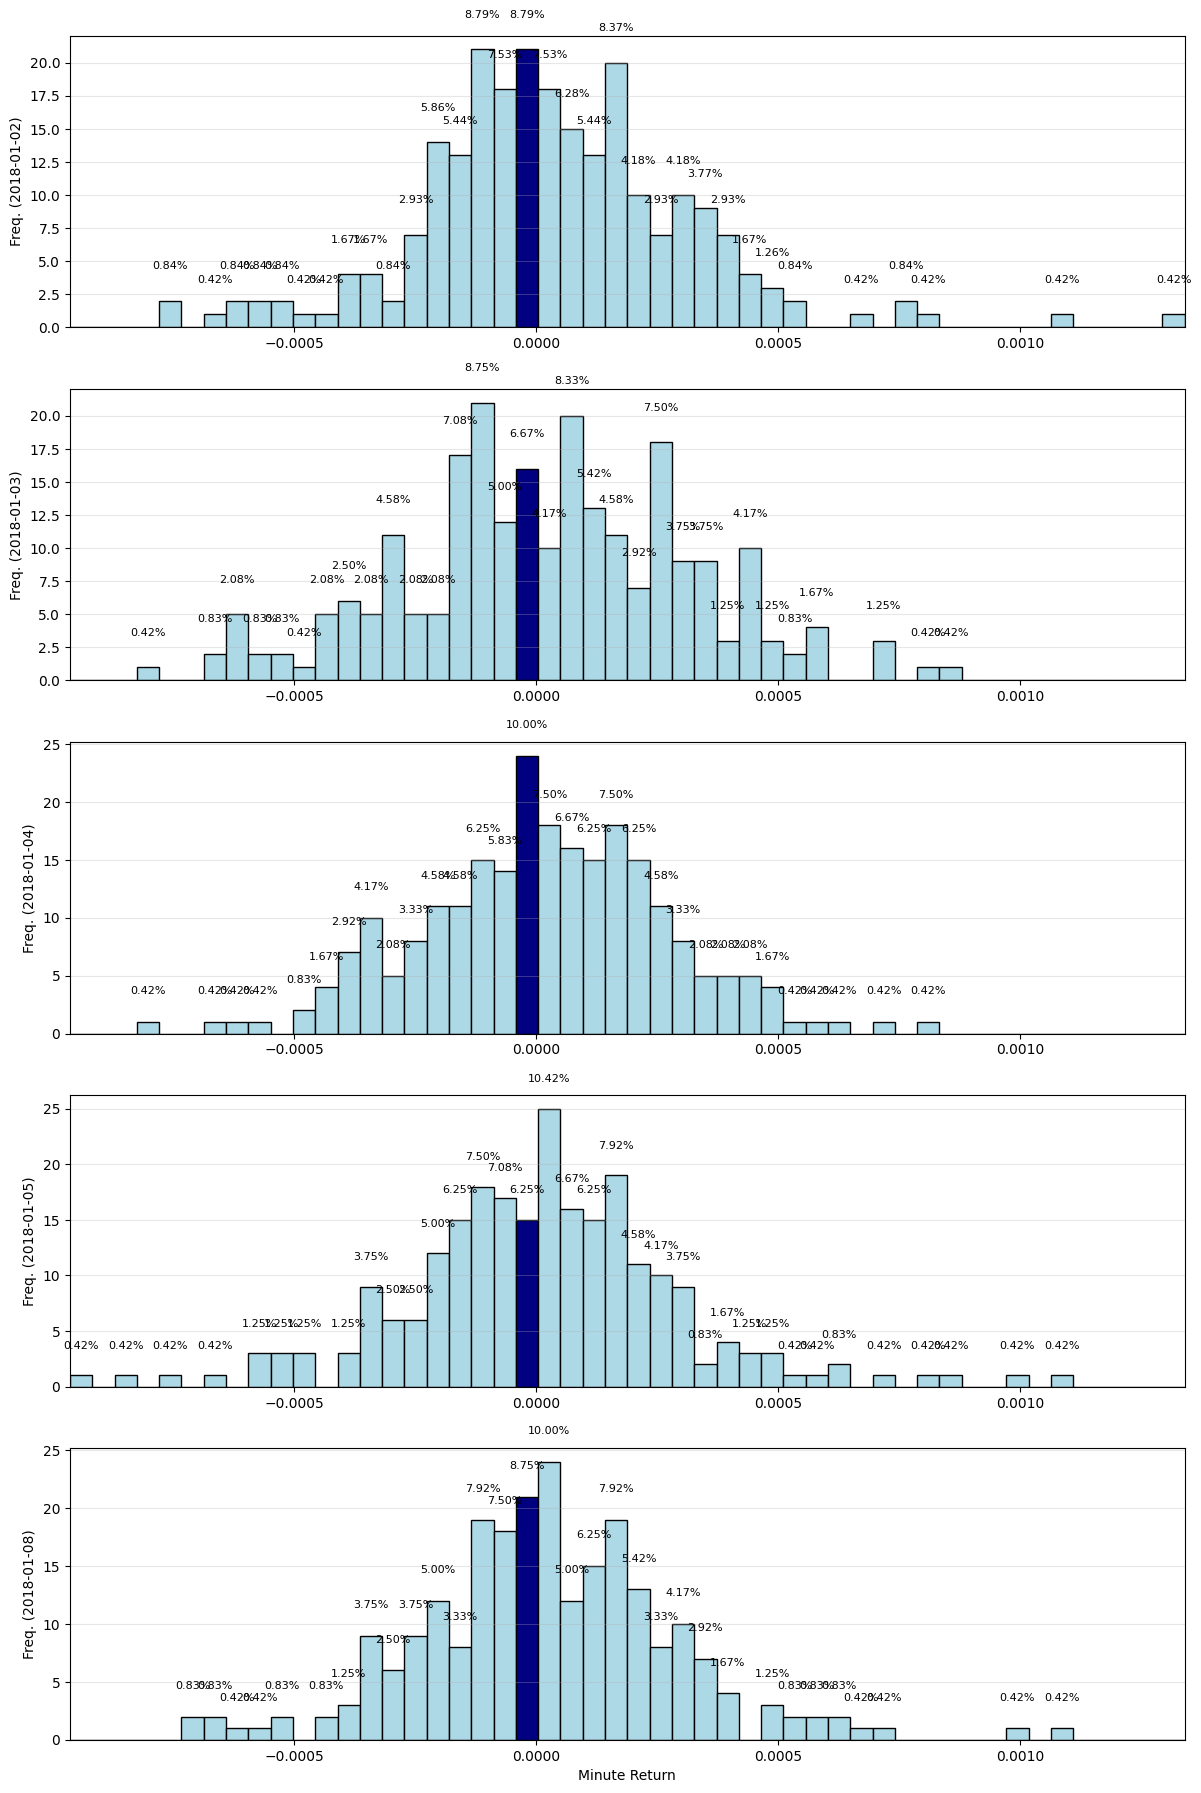

In [8]:
# 1. Select 5 consecutive trading days starting from '2018-01-02'.
target_date = pd.to_datetime('2018-01-02').date()
unique_dates = sorted(df['date'].unique())
selected_dates = [d for d in unique_dates if d >= target_date][:5]

if len(selected_dates) < 5:
    print("Not enough trading days available!")
else:
    # 2. Data from the selected five days to set global bin edges.
    selected_data = df[df['date'].isin(selected_dates)]
    
    # 3. Compute global min/max returns for consistent bins.
    global_min = selected_data['returns'].min()
    global_max = selected_data['returns'].max()
    
    # 4. Uniform bins: 50 bins (51 edges).
    bin_edges = np.linspace(global_min, global_max, 51)
    
    # 5. Create subplots (5 rows, 1 column).
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 18))
    
    # 6. Loop through each day to plot histograms and annotate probabilities.
    for i, day in enumerate(selected_dates):
        day_df = df[df['date'] == day]
        returns = day_df['returns'].dropna()
        
        # Histogram plotting.
        counts, bins, patches = axs[i].hist(returns, bins=bin_edges, edgecolor='black')

        total_returns = counts.sum()
        
        # Annotate probabilities at the top of each bin.
        for count, bin_left, patch in zip(counts, bins, patches):
            if count > 0:
                prob = count / total_returns
                # Place probability slightly above the bar.
                axs[i].text(bin_left + patch.get_width()/2, count + total_returns*0.01, 
                            f'{prob:.2%}', ha='center', fontsize=8, color='black')
        
        # Formatting the plots.
        axs[i].set_ylabel(f"Freq. ({day})")
        axs[i].set_xlim(global_min, global_max)
        
        # Color bars: zero-containing bin highlighted.
        for patch in patches:
            x = patch.get_x()
            width = patch.get_width()
            if x <= 0 < x + width:
                patch.set_facecolor("navy")
            else:
                patch.set_facecolor("lightblue")
        
        axs[i].grid(axis='y', alpha=0.3)
    
    # Common x-axis label for all histograms.
    axs[-1].set_xlabel("Minute Return")
    
    plt.tight_layout()
    plt.show()

Inputs:
	•	df: DataFrame with columns 'datetime', 'date', and 'return'.
	•	specific_date: Target day for ambiguity calculation.
	•	window_size (n): Number of days to consider for rolling calculation.
	•	num_bins: Number of intervals for return distributions.

Ambiguity Definition:
	•	Ambiguity for day t is calculated from the probability distributions of minute returns from day t-n+1 to day t.
	•	Ambiguity metric: standard deviation of interval probabilities across the selected days, averaged over intervals.

In [9]:

def calculate_daily_ambiguity(df, specific_date, window_size=5, num_bins=50):
    # Ensure 'date' is in datetime.date format
    df['date'] = pd.to_datetime(df['date']).dt.date
    
    specific_date = pd.to_datetime(specific_date).date()

    # Step 1: Identify dates for the rolling window
    unique_dates = sorted(df['date'].unique())
    if specific_date not in unique_dates:
        raise ValueError("The specific_date is not available in the DataFrame.")
    
    date_index = unique_dates.index(specific_date)
    if date_index < window_size - 1:
        raise ValueError("Insufficient historical data for the specified window size.")
    
    # Rolling window dates
    window_dates = unique_dates[date_index - window_size + 1: date_index + 1]

    # Step 2: Select returns within the window
    window_df = df[df['date'].isin(window_dates)].copy()

    # Step 3: Create bins (intervals) from min to max return in window
    min_return, max_return = window_df['returns'].min(), window_df['returns'].max()
    bins = np.linspace(min_return, max_return, num_bins + 1)

    # Step 4: Calculate daily probabilities
    daily_probabilities = []
    for day in window_dates:
        daily_returns = window_df[window_df['date'] == day]['returns'].dropna()
        counts, _ = np.histogram(daily_returns, bins=bins)
        probs = counts / counts.sum() if counts.sum() > 0 else np.zeros(num_bins)
        daily_probabilities.append(probs)

        # Optional debug print:
        #print(f"Date: {day}, Probabilities: {probs}")

    # Convert to DataFrame (days as rows, bins as columns)
    probs_df = pd.DataFrame(daily_probabilities, index=window_dates)

    # Step 5: Compute interval-wise ambiguity (standard deviation across days)
    interval_std = probs_df.std(axis=0)

    print("\nInterval-wise Ambiguity (Standard Deviation across probabilities):")
    print(interval_std)

    # Step 6: Compute overall ambiguity metric as average across intervals
    daily_ambiguity_metric = interval_std.mean()

    print(f"\nOverall Ambiguity on {specific_date}: {daily_ambiguity_metric:.6f}")

    return daily_ambiguity_metric, interval_std

# Example usage:
ambiguity_metric, interval_std = calculate_daily_ambiguity(df, '2018-01-09', window_size=5, num_bins=50)


Interval-wise Ambiguity (Standard Deviation across probabilities):
0     0.001863
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.001863
11    0.000000
12    0.000000
13    0.001863
14    0.000000
15    0.003486
16    0.002282
17    0.008122
18    0.006180
19    0.004167
20    0.003486
21    0.006847
22    0.003486
23    0.004564
24    0.003727
25    0.014130
26    0.014554
27    0.009033
28    0.014613
29    0.024116
30    0.012360
31    0.008015
32    0.014849
33    0.010458
34    0.014907
35    0.010623
36    0.005590
37    0.012148
38    0.005590
39    0.003486
40    0.006319
41    0.004167
42    0.008640
43    0.002946
44    0.002282
45    0.002282
46    0.002282
47    0.000000
48    0.002282
49    0.002282
dtype: float64

Overall Ambiguity on 2018-01-09: 0.005198
